In [ ]:
pip install rasterio rioxarray xarray pandas numpy matplotlib scipy


In [4]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
import xarray as xr
import os

# Create directories
os.makedirs("data", exist_ok=True)

# Dummy raster metadata
width = height = 100
transform = from_origin(78.0, 31.0, 0.0003, 0.0003)  # origin_x, origin_y, pixel_width, pixel_height
crs = "EPSG:4326"

# 1. Create DEM dummy file
dem_data = np.random.rand(height, width).astype(np.float32) * 1000  # Elevation values
with rasterio.open(
    "data/uttarakhand_dem.tif", "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=dem_data.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(dem_data, 1)

# 2. Create LULC dummy file (land cover classes 1 to 5)
lulc_data = np.random.randint(1, 6, size=(height, width)).astype(np.uint8)
with rasterio.open(
    "data/lulc_uttarakhand.tif", "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=lulc_data.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(lulc_data, 1)

# 3. Create weather NetCDF file with dummy variables: temperature, humidity, wind_speed
time = np.array(["2024-06-22"], dtype="datetime64")
lat = np.linspace(30.0, 31.0, height)
lon = np.linspace(78.0, 79.0, width)

weather_ds = xr.Dataset(
    {
        "temperature": (("time", "lat", "lon"), np.random.uniform(15, 40, size=(1, height, width))),
        "humidity": (("time", "lat", "lon"), np.random.uniform(10, 90, size=(1, height, width))),
        "wind_speed": (("time", "lat", "lon"), np.random.uniform(0, 20, size=(1, height, width))),
    },
    coords={"time": time, "lat": lat, "lon": lon}
)

weather_ds.to_netcdf("data/weather_2024.nc")

"Dummy files created: uttarakhand_dem.tif, lulc_uttarakhand.tif, weather_2024.nc"


'Dummy files created: uttarakhand_dem.tif, lulc_uttarakhand.tif, weather_2024.nc'

In [14]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
import os

# Create dummy VIIRS fire raster
height, width = 100, 100
transform = from_origin(78.0, 31.0, 0.0003, 0.0003)

fire_map = np.zeros((height, width), dtype=np.uint8)
fire_map[40:50, 40:50] = 1  # Add a fire zone in the center

os.makedirs("data", exist_ok=True)

with rasterio.open(
    "data/viirs_fire_2023.tif",
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=fire_map.dtype,
    crs="EPSG:4326",
    transform=transform,
) as dst:
    dst.write(fire_map, 1)

print("✅ Dummy VIIRS fire raster created!")


✅ Dummy VIIRS fire raster created!


In [5]:
import rasterio
import numpy as np
import xarray as xr
import rioxarray as rxr
import os
from scipy.ndimage import sobel


def read_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # read first band
        profile = src.profile
    return data, profile


def compute_slope_aspect(dem_array):
    """Returns slope and aspect in degrees."""
    dx = sobel(dem_array, axis=1)
    dy = sobel(dem_array, axis=0)

    slope = np.sqrt(dx**2 + dy**2)
    slope_deg = np.arctan(slope) * (180 / np.pi)

    aspect = np.arctan2(-dx, dy)
    aspect_deg = (aspect * 180 / np.pi) % 360

    return slope_deg, aspect_deg


def read_weather_netcdf(file_path, variable):
    """Reads a weather NetCDF file and returns a 2D slice for a given variable."""
    ds = xr.open_dataset(file_path)
    data_slice = ds[variable].isel(time=0)  # take first timestep
    return data_slice.values


def stack_features(dem_path, lulc_path, weather_nc_path):
    dem, profile = read_raster(dem_path)
    lulc, _ = read_raster(lulc_path)

    slope, aspect = compute_slope_aspect(dem)

    temp = read_weather_netcdf(weather_nc_path, "temperature")
    humidity = read_weather_netcdf(weather_nc_path, "humidity")
    wind = read_weather_netcdf(weather_nc_path, "wind_speed")

    stacked = np.stack([dem, slope, aspect, lulc, temp, humidity, wind], axis=0)
    return stacked, profile


if __name__ == "__main__":
    # DEM, LULC, and weather data for Uttarakhand
    DEM = "data/uttarakhand_dem.tif"
    LULC = "data/lulc_uttarakhand.tif"
    WEATHER = "data/weather_2024.nc"

    features, meta = stack_features(DEM, LULC, WEATHER)
    print("Feature stack shape:", features.shape)


Feature stack shape: (7, 100, 100)


In [15]:
import rasterio
import numpy as np
import xarray as xr
import rioxarray as rxr
from scipy.ndimage import sobel
import os


def read_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        profile = src.profile
    return data, profile


def compute_slope_aspect(dem_array):
    dx = sobel(dem_array, axis=1)
    dy = sobel(dem_array, axis=0)

    slope = np.sqrt(dx**2 + dy**2)
    slope_deg = np.arctan(slope) * (180 / np.pi)

    aspect = np.arctan2(-dx, dy)
    aspect_deg = (aspect * 180 / np.pi) % 360

    return slope_deg, aspect_deg


def read_weather_netcdf(file_path, variable):
    ds = xr.open_dataset(file_path)
    data_slice = ds[variable].isel(time=0)
    return data_slice.values


def stack_features(dem_path, lulc_path, weather_nc_path):
    dem, profile = read_raster(dem_path)
    lulc, _ = read_raster(lulc_path)

    slope, aspect = compute_slope_aspect(dem)

    temp = read_weather_netcdf(weather_nc_path, "temperature")
    humidity = read_weather_netcdf(weather_nc_path, "humidity")
    wind = read_weather_netcdf(weather_nc_path, "wind_speed")

    stacked = np.stack([dem, slope, aspect, lulc, temp, humidity, wind], axis=0)
    return stacked, profile


def normalize_channels(data_stack):
    norm_stack = np.zeros_like(data_stack, dtype=np.float32)
    for i in range(data_stack.shape[0]):
        band = data_stack[i]
        min_val = np.nanmin(band)
        max_val = np.nanmax(band)
        norm_stack[i] = (band - min_val) / (max_val - min_val + 1e-6)
    return norm_stack


def save_stack_as_npz(stack, save_path="data/feature_stack.npz"):
    np.savez_compressed(save_path, features=stack)
    print(f"✅ Feature stack saved to: {save_path}")


def prepare_target_label(viirs_path, target_path, threshold=0):
    viirs_data, _ = read_raster(viirs_path)
    label = (viirs_data > threshold).astype(np.uint8)
    np.save(target_path, label)
    print(f"✅ Saved binary label map to: {target_path}")
    return label


# 🔁 CLI-style runner
if __name__ == "__main__":
    # Paths
    DEM = "data/uttarakhand_dem.tif"
    LULC = "data/lulc_uttarakhand.tif"
    WEATHER = "data/weather_2024.nc"
    VIIRS = "data/viirs_fire_2023.tif"

    print("📥 Reading and stacking features...")
    features, meta = stack_features(DEM, LULC, WEATHER)
    print("✅ Original shape:", features.shape)

    print("⚖️ Normalizing feature channels...")
    norm_features = normalize_channels(features)
    print("✅ Normalized shape:", norm_features.shape)

    print("💾 Saving feature stack...")
    save_stack_as_npz(norm_features)

    print("🔥 Preparing target label map...")
    prepare_target_label(VIIRS, "data/target_labels.npy")


📥 Reading and stacking features...
✅ Original shape: (7, 100, 100)
⚖️ Normalizing feature channels...
✅ Normalized shape: (7, 100, 100)
💾 Saving feature stack...
✅ Feature stack saved to: data/feature_stack.npz
🔥 Preparing target label map...
✅ Saved binary label map to: data/target_labels.npy


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio


def show_label_overlay(dem_path, label_path):
    """
    Show binary label mask over DEM.
    Fire = red; background = grayscale DEM.
    """
    # Read DEM
    with rasterio.open(dem_path) as src:
        dem = src.read(1)

    # Load label map
    label = np.load(label_path)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(dem, cmap="gray", interpolation='none')
    plt.imshow(label, cmap="Reds", alpha=0.5, interpolation='none')
    plt.title("Fire Labels Overlay on DEM")
    plt.colorbar(label="Elevation")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


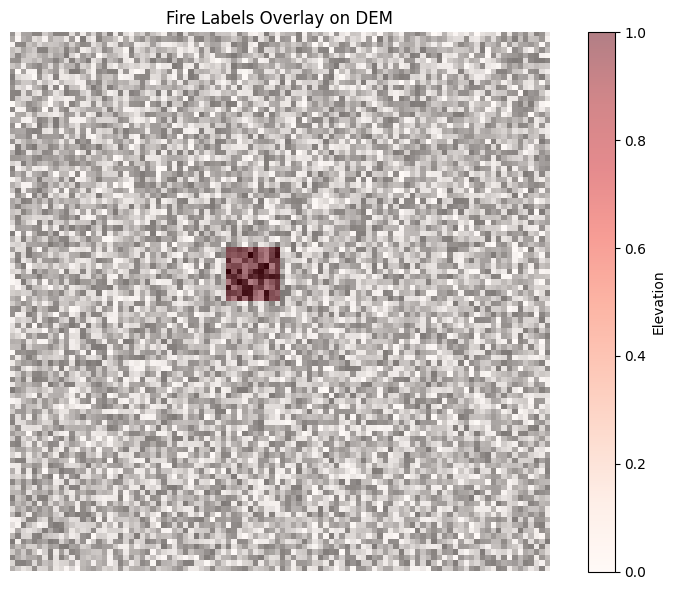

In [19]:
# from forestfire_sim.visualize import show_label_overlay

show_label_overlay("data/uttarakhand_dem.tif", "data/target_labels.npy")
